# 1. Introduction

In this post I am going to talk about how to apply the natural lanugage processing techniques to the recommender system. In many real cases, for instance, if we have finished a course in Coursera, we want to learn some related courses to get a deeper insight into one research field. Hence, it would be better if our online system could automatically recommend some relevant courses for a learner.

If we talk more about this coursera case, some people might say we could use labels to tag all the courses previously and if one learner finished one course, based on the label the system would post some relevant courses. However, manually labelling huge number of courses is very time consuming. Moreover, some algorithms such as collaborative filtering and content-based filtering could also help this problem. But these approaches would not work if we had a new course on Coursera and we did not have much feedback(data) from users about this course. **A better approach** to this problem is that we utilize the title and the description of each course and use NLP techniques to work out for instance the similarity of two courses. Based on this similarity, our system could automatically recommende coursers to our users. The following sections will show the main techniques we use.

So let's get started!

# 2. Construct the NLP Models

In this section we show how to create a recommendation system for our Coursera users. Let's first import modules for this task.

## 2.1 Load the dataset

First we import all the modules we need in this case study.

In [31]:
import nltk
import re
import string
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer

from gensim import corpora, models, similarities

from sklearn.decomposition import NMF

Then we load the data. The data can be found in here: [Coursera corpus](https://github.com/bright1993ff66/Text-Data-Analysis/blob/master/Recommender%20System/coursera_corpus)

In [2]:
file = open('F:/Data Analysis/github/Text-Data-Analysis/Recommender System/coursera_corpus', encoding = 'gb18030', 
            errors = 'ignore')
courses = [line.strip() for line in file]
courses[:2]

['Writing II: Rhetorical Composing\tRhetorical Composing engages you in a series of interactive reading, research, and composing activities along with assignments designed to help you become more effective consumers and producers of alphabetic, visual and multimodal texts.  Join us to become more effective writers... and better citizens.\tRhetorical Composing is a course where writers exchange words, ideas,     talents, and support. You will be introduced to a variety of rhetorical     concepts鈥攖hat is, ideas and techniques to inform and persuade audiences鈥攖hat     will help you become a more effective consumer and producer of written,     visual, and multimodal texts. The class includes short videos, demonstrations,     and activities. We envision Rhetorical Composing as a learning community that includes both those enrolled in this course and the instructors. We bring our expertise in writing, rhetoric and course design, and we have designed the assignments and course infrastructure 

From the output, we see that the names of the courses are seperated by tab. Hence we use the following code to extract the courses' names.

In [3]:
courses_name = [course.split('\t')[0] for course in courses]
courses_name[:10]

['Writing II: Rhetorical Composing',
 'Genetics and Society: A Course for Educators',
 'General Game Playing',
 'Genes and the Human Condition (From Behavior to Biotechnology)',
 'A Brief History of Humankind',
 'New Models of Business in Society',
 'Analyse Num茅rique pour Ing茅nieurs',
 'Evolution: A Course for Educators',
 'Coding the Matrix: Linear Algebra through Computer Science Applications',
 'The Dynamic Earth: A Course for Educators']

## 2.2 Preprocess the data

Generally, we need to do the following text pre-processing:

1. lowercase the words
2. eliminate punctuations
3. eliminate the stopwords
3. stemming

In [4]:
text_lower = [[word for word in document.lower().split()] for document in courses]
print(text_lower[0], end = '\t')

['writing', 'ii:', 'rhetorical', 'composing', 'rhetorical', 'composing', 'engages', 'you', 'in', 'a', 'series', 'of', 'interactive', 'reading,', 'research,', 'and', 'composing', 'activities', 'along', 'with', 'assignments', 'designed', 'to', 'help', 'you', 'become', 'more', 'effective', 'consumers', 'and', 'producers', 'of', 'alphabetic,', 'visual', 'and', 'multimodal', 'texts.', 'join', 'us', 'to', 'become', 'more', 'effective', 'writers...', 'and', 'better', 'citizens.', 'rhetorical', 'composing', 'is', 'a', 'course', 'where', 'writers', 'exchange', 'words,', 'ideas,', 'talents,', 'and', 'support.', 'you', 'will', 'be', 'introduced', 'to', 'a', 'variety', 'of', 'rhetorical', 'concepts鈥攖hat', 'is,', 'ideas', 'and', 'techniques', 'to', 'inform', 'and', 'persuade', 'audiences鈥攖hat', 'will', 'help', 'you', 'become', 'a', 'more', 'effective', 'consumer', 'and', 'producer', 'of', 'written,', 'visual,', 'and', 'multimodal', 'texts.', 'the', 'class', 'includes', 'short', 'videos,', 'demonstr

From the text above, we see some output such as 'texts.' does not split the word and the punctuation. Hence, it would be better if we could use the **word_tokenize** function in nltk and get a more meaningful result.

In [5]:
text_lower = [[word.lower() for word in word_tokenize(document)] for document in courses]
print(text_lower[0], end = '\t')

['writing', 'ii', ':', 'rhetorical', 'composing', 'rhetorical', 'composing', 'engages', 'you', 'in', 'a', 'series', 'of', 'interactive', 'reading', ',', 'research', ',', 'and', 'composing', 'activities', 'along', 'with', 'assignments', 'designed', 'to', 'help', 'you', 'become', 'more', 'effective', 'consumers', 'and', 'producers', 'of', 'alphabetic', ',', 'visual', 'and', 'multimodal', 'texts', '.', 'join', 'us', 'to', 'become', 'more', 'effective', 'writers', '...', 'and', 'better', 'citizens', '.', 'rhetorical', 'composing', 'is', 'a', 'course', 'where', 'writers', 'exchange', 'words', ',', 'ideas', ',', 'talents', ',', 'and', 'support', '.', 'you', 'will', 'be', 'introduced', 'to', 'a', 'variety', 'of', 'rhetorical', 'concepts鈥攖hat', 'is', ',', 'ideas', 'and', 'techniques', 'to', 'inform', 'and', 'persuade', 'audiences鈥攖hat', 'will', 'help', 'you', 'become', 'a', 'more', 'effective', 'consumer', 'and', 'producer', 'of', 'written', ',', 'visual', ',', 'and', 'multimodal', 'texts', '.

The words and the punctuations have been splitted. Then we need to do is eliminate the punctuatiaons.

In [6]:
x = re.compile('[%s]' % re.escape(string.punctuation))
text_lower_no_punctuation = []

for text in text_lower:
    new_text = []
    for token in text:
        new_token = x.sub(u'',token) 
        if not new_token == u'':
            new_text.append(new_token)
    text_lower_no_punctuation.append(new_text)
    
print(text_lower_no_punctuation[0], end = "\t")

['writing', 'ii', 'rhetorical', 'composing', 'rhetorical', 'composing', 'engages', 'you', 'in', 'a', 'series', 'of', 'interactive', 'reading', 'research', 'and', 'composing', 'activities', 'along', 'with', 'assignments', 'designed', 'to', 'help', 'you', 'become', 'more', 'effective', 'consumers', 'and', 'producers', 'of', 'alphabetic', 'visual', 'and', 'multimodal', 'texts', 'join', 'us', 'to', 'become', 'more', 'effective', 'writers', 'and', 'better', 'citizens', 'rhetorical', 'composing', 'is', 'a', 'course', 'where', 'writers', 'exchange', 'words', 'ideas', 'talents', 'and', 'support', 'you', 'will', 'be', 'introduced', 'to', 'a', 'variety', 'of', 'rhetorical', 'concepts鈥攖hat', 'is', 'ideas', 'and', 'techniques', 'to', 'inform', 'and', 'persuade', 'audiences鈥攖hat', 'will', 'help', 'you', 'become', 'a', 'more', 'effective', 'consumer', 'and', 'producer', 'of', 'written', 'visual', 'and', 'multimodal', 'texts', 'the', 'class', 'includes', 'short', 'videos', 'demonstrations', 'and', 'a

The punctuations have been removed. After that, we need to remove the unmeaningful stopwords. Fortunately, nltk provides us with a list of stopwords which are helpful in this task.

In [7]:
english_stopwords = stopwords.words('english')

In [8]:
text_filtered = [[word for word in document if word not in english_stopwords ] for document in text_lower_no_punctuation]
print(text_filtered[0], end = "\t")

['writing', 'ii', 'rhetorical', 'composing', 'rhetorical', 'composing', 'engages', 'series', 'interactive', 'reading', 'research', 'composing', 'activities', 'along', 'assignments', 'designed', 'help', 'become', 'effective', 'consumers', 'producers', 'alphabetic', 'visual', 'multimodal', 'texts', 'join', 'us', 'become', 'effective', 'writers', 'better', 'citizens', 'rhetorical', 'composing', 'course', 'writers', 'exchange', 'words', 'ideas', 'talents', 'support', 'introduced', 'variety', 'rhetorical', 'concepts鈥攖hat', 'ideas', 'techniques', 'inform', 'persuade', 'audiences鈥攖hat', 'help', 'become', 'effective', 'consumer', 'producer', 'written', 'visual', 'multimodal', 'texts', 'class', 'includes', 'short', 'videos', 'demonstrations', 'activities', 'envision', 'rhetorical', 'composing', 'learning', 'community', 'includes', 'enrolled', 'course', 'instructors', 'bring', 'expertise', 'writing', 'rhetoric', 'course', 'design', 'designed', 'assignments', 'course', 'infrastructure', 'help', '

At last, we do the stemming for this text. Stemming in NLP means that we treat each word's different variants as the same word. For instance for playing, played, play, we see them as a same word:play. nltk has many useful stemmers. The most well-know ones are Lancaster Stemmer and Porter Stemmer. Here we use Lancaster Stemmer to cope with this Coursera corpus.

In [9]:
st = LancasterStemmer()
text_stemmed = [[st.stem(word) for word in docment] for docment in text_filtered]
print(text_stemmed[0], end = "\t")

['writ', 'ii', 'rhet', 'compos', 'rhet', 'compos', 'eng', 'sery', 'interact', 'read', 'research', 'compos', 'act', 'along', 'assign', 'design', 'help', 'becom', 'effect', 'consum', 'produc', 'alphabet', 'vis', 'multimod', 'text', 'join', 'us', 'becom', 'effect', 'writ', 'bet', 'cit', 'rhet', 'compos', 'cours', 'writ', 'exchang', 'word', 'idea', 'tal', 'support', 'introduc', 'vary', 'rhet', 'concepts鈥攖h', 'idea', 'techn', 'inform', 'persuad', 'audiences鈥攖h', 'help', 'becom', 'effect', 'consum', 'produc', 'writ', 'vis', 'multimod', 'text', 'class', 'includ', 'short', 'video', 'demonst', 'act', 'envid', 'rhet', 'compos', 'learn', 'commun', 'includ', 'enrol', 'cours', 'instruct', 'bring', 'expert', 'writ', 'rhet', 'cours', 'design', 'design', 'assign', 'cours', 'infrastruct', 'help', 'shar', 'expery', 'writ', 'stud', 'profess', 'us', 'collab', 'facilit', 'wex', 'writ', 'exchang', 'plac', 'exchang', 'work', 'feedback']	

## 2.3 Train the data

We have finished the text data preprocessing. Next, we will fead the data to our NLP models. First, let's construct a bag-of-words model.

In [10]:
dictionary = corpora.Dictionary(text_stemmed)

Then we construct the bag-of-words model.

In [11]:
print(dictionary)

Dictionary(6167 unique tokens: ['diagnostic', '鈥渢echnolog', 'mechanismbas', 'n茅cessite', 'perpet']...)


From the dictionary, we get the id of each unique word. Then we could calculate how many times a word appears in this Coursera corpus.

In [12]:
'''
doc2bow converts `document` (a list of words) into the bag-of-words format
'''
corpus = [dictionary.doc2bow(text) for text in text_stemmed] 

In [13]:
print(corpus[0], end = ' ')

[(0, 1), (1, 1), (2, 2), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1), (8, 5), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 2), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 3), (31, 2), (32, 2), (33, 7), (34, 1), (35, 1), (36, 3), (37, 2), (38, 1), (39, 1), (40, 1), (41, 6), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 3), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 3), (58, 1), (59, 2), (60, 1), (61, 4)] 

In [14]:
len(corpus)

379

For instance, the first output (0,1) means that the id 0 (which is the word 'design') occurs 3 times in a corpus. More specifically, it means the word 'design' occurs 3 times in text_stemmed[0]

In [15]:
list(dictionary.token2id.keys())[list(dictionary.token2id.values()).index(0)]

'expert'

Then we could construct the TF-IDF model. The value of TF-IDF could be calculated as follows:

\begin{equation}
TF-IDF(x) = TF(X) \times IDF(X)
\end{equation}

where $TF(x)$ means the word frequency of a word $x$. $IDF(x)$ represents the importance of a word $X$. We usually use the following formular to calcualte the $IDF(X)$:

\begin{equation}
IDF(X) = log\frac{N+1}{N(x)+1} + 1
\end{equation}

where $N$ means the number of documents and $N(x)$ means the number of documents with word $x$. Sometimes, we could not find the term $x$ in all of our documents. Hence, it would be better if we could just add 1 to both of numerator and the denominator.

Hence, we could train a TF-IDF model based on our bag-of-words format.

In [16]:
tfidf = models.TfidfModel(corpus)

Then we could calculate the TF-IDF value for each word in this corpus.

In [17]:
corpus_tfidf = tfidf[corpus]

In [18]:
docs = [doc for doc in corpus_tfidf]
print(docs[0], end =' ')

[(0, 0.06356315123530916), (1, 0.08326161336877998), (2, 0.082170178357927), (3, 0.10920030859393032), (4, 0.022030147784449523), (5, 0.018615393495326763), (6, 0.05093850343205337), (7, 0.05542000190122536), (8, 0.38741978484543227), (9, 0.042795354097969585), (10, 0.024482508739581715), (11, 0.04842479227956166), (12, 0.10532556843664105), (13, 0.011667494796360069), (14, 0.10907749209824724), (15, 0.07300245849991446), (16, 0.03635916403274908), (17, 0.061001377402935375), (18, 0.050279969766526385), (19, 0.12022360096920506), (20, 0.11924637417041838), (21, 0.06934080763500267), (22, 0.06934080763500267), (23, 0.04236546424533216), (24, 0.017319235564805236), (25, 0.11924637417041838), (26, 0.11924637417041838), (27, 0.03074412777174355), (28, 0.06934080763500267), (29, 0.11924637417041838), (30, 0.22535539210408861), (31, 0.10920030859393032), (32, 0.07901821252782935), (33, 0.31265453453864595), (34, 0.05542000190122536), (35, 0.03480152498628928), (36, 0.12974006157158152), (37,

Then we use **Latent Semantic Index(LSI)** or **Latent Semantic Analysis(LSA)** model to train our data. The KSI model assumes that **words that are close in meaning will occur in similar pieces**. The LSI model is based on singular value decomposition(SVD). If we use SVD and implement PCA with first $k$ features, for a $m \times n$ matrix $A$, we could get：

\begin{equation}
A_{m \times n} \approx U_{m \times k} \Sigma_{k \times k} V_{k \times n}
\end{equation}

We always use $A_{m \times n}$ to represent the feature value of mth word in the nth document. In this case, we use TF-IDF value to be this feature value. Then for the terms $ U_{m \times k}, \Sigma_{k \times k}$ and $V_{k \times n} $:

1. $U_{m \times k}$ represents the correlation between mth word and kth topic
2. $\Sigma_{k \times k}$ represents the correlatiion between the topics
3. $V_{k \times n} $ represents the correlation between the kth topic and the nth document.

The following figure shows the general idea of LSI:

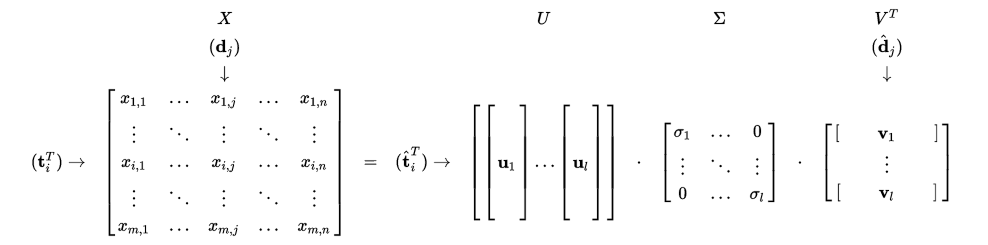

Hence for the function models.LsiModel, we use the TF-IDF values as the inputs and we assume that there are 10 different topics for this Coursera dataset. Then we could construct the following LSI model:

In [19]:
lsi = models.LsiModel(corpus = corpus_tfidf, id2word=dictionary, num_topics=10)

With this LSI model, we could project our corpus to a 10-dimensional space.

In [20]:
corpus_lsi = lsi[corpus_tfidf]

Then we could compute the similarity between different documents.

In [21]:
index = similarities.MatrixSimilarity(lsi[corpus])

For instance, if a user has finished Andrew Ng's course Machine learning, he wants to study other courses which also contains machine learning. Hence, firstly we construct the bag-of-words framework for this course.

In [22]:
ml_course = text_stemmed[210]
ml_bow = dictionary.doc2bow(ml_course)

In [23]:
ml_lsi = lsi[ml_bow]
print(ml_lsi)

[(0, -8.6971891516311803), (1, 0.6756483706633416), (2, 1.0892949978946991), (3, -0.0093186486061790624), (4, -4.4757855681268062), (5, 0.36841044228752684), (6, 2.0171844170169106), (7, 1.5613763675351147), (8, 0.3044796100380609), (9, -0.69103130409389613)]


In [24]:
sims = index[ml_lsi]

In [25]:
sort_sims = sorted(enumerate(sims), key=lambda item: -item[1])
print(sort_sims[:10])

[(210, 1.0), (174, 0.97889173), (189, 0.94530272), (238, 0.94380879), (63, 0.94207221), (184, 0.93176055), (141, 0.92864418), (203, 0.92150527), (219, 0.92006952), (221, 0.91825765)]


Hence we finally get the courses which are most close to Andrew's course 'machine learning' are:

In [26]:
course_id = [course[0] for course in sort_sims[:10]]
top_10_courses = [courses_name[i] for i in course_id]
print(top_10_courses)

['Machine Learning', 'Machine Learning', 'Computer Security', 'Probabilistic Graphical Models', 'Human-Computer Interaction', 'Computer Science 101', 'Computational Photography', 'Neural Networks for Machine Learning', 'Cryptography II', 'Heterogeneous Parallel Programming']


The results look quite reasonable. But the LSI model does have the following **issues**:

1. This model is computationally expensive, especially when we are analyzing the large corpus(The speed could be improved by implementing the NMF decomposition).
2. It is hard to select the appropriate $k$.
3. The result, for instance the output given by the code below, is hard to interpret.

```Python
index = similarities.MatrixSimilarity(lsi[corpus])
```

To speed up the computation, we sometimes use **NMF** decomposition. The general idea of this decomposition is that we want to each value computed by $W$ and $H$ is similar to the value in $V$:

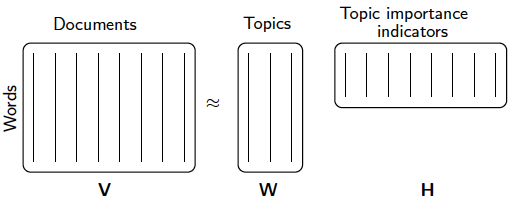